In [1]:
import hipp
import usgsxplore
import os
import shutil
import pandas as pd
from pathlib import Path

# Settings

In [2]:


_project_dirs = {
    "a90" : Path("/mnt/summer/USERS/DEHECQA/history/data_prep/casa_grande/aerial_images/1990_10_31_aux"),
    "a71_25" : Path("/mnt/summer/USERS/DEHECQA/history/data_prep/casa_grande/aerial_images/1971_01_25_aux"),
    "a71_24" : Path("/mnt/summer/USERS/DEHECQA/history/data_prep/casa_grande/aerial_images/1971_01_24_aux"),
    "a71_19" : Path("/mnt/summer/USERS/DEHECQA/history/data_prep/casa_grande/aerial_images/1971_01_19_aux"),


}
paths = {k:{} for k in _project_dirs}
for ds_name, dir in _project_dirs.items():
    paths[ds_name]["raw_images"] = dir / "raw_images"
    paths[ds_name]["preproc_images"] = dir / "preprocessed_images"
    paths[ds_name]["crop_images"] = dir / "cropped_images"
    paths[ds_name]["fiducial_templates"] = dir / "fiducial_templates"
    paths[ds_name]["qc"] = dir / "qc"
    paths[ds_name]["detected_fiducials"] = paths[ds_name]["raw_images"] / "detected_fiducial_markers.csv"
    paths[ds_name]["tf_detected_fiducials"] = paths[ds_name]["preproc_images"] / "detected_fiducial_markers.csv"
    paths[ds_name]["crop_detected_fiducials"] = paths[ds_name]["crop_images"] / "detected_fiducial_markers.csv"
    paths[ds_name]["intrinsics"] = dir / "camera_model_intrinsics.csv"
    paths[ds_name]["extrinsics"] = dir / "camera_model_extrinsics.csv"
    paths[ds_name]["footprint"] = dir / "images_footprint.geojson"
    paths[ds_name]["dir"] = dir
    dir.mkdir(parents=True, exist_ok=True)

MAX_WORKERS = 4
QUICKVIEW_FACTOR = 0.2
OVERWRITE = False

## Downloading the datasets

| Dataset Name | Date | Images Count | 
|--|--|--|
| a90 | 1990-10-31 | 122 |
| a71_25 | 1971-01-25 | 12 |
| a71_24 | 1971-01-24 | 5 |
| a71_19 | 1971-01-19 | 17 |



In [ ]:
# connect to the api using your username and token
username = os.getenv("USGS_USERNAME") or input("Enter your USGS username: ")
token = os.getenv("USGS_TOKEN") or input("Enter your USGS token: ")
api = usgsxplore.API(username, token)

datasets_metadatas = {
    "a90" : {
        "dataset":"aerial_combin",
        "bbox": [-111.87783, 32.66157, -111.60280, 32.89378],
        "date_interval": ("1990-10-31", "1990-10-31"),
        "meta_filter": "HIGH_AVAILABLE=Yes",
        "product_number": 1 # 0: medium res, 1: high res, 2: calibration report
    },
    "a71_25" : {
        "dataset":"aerial_combin",
        "bbox": [-111.87783, 32.66157, -111.60280, 32.89378],
        "date_interval": ("1971-01-25", "1971-01-25"),
        "meta_filter": "HIGH_AVAILABLE=Yes&REC_TECH=1", # REC_TECH=1 for only images with fiducials
        "product_number": 0 # 0: high res, 1: calibration report
    },
    "a71_24" : {
        "dataset":"aerial_combin",
        "bbox": [-111.87783, 32.66157, -111.60280, 32.89378],
        "date_interval": ("1971-01-24", "1971-01-24"),
        "meta_filter": "HIGH_AVAILABLE=Yes&REC_TECH=1", # REC_TECH=1 for only images with fiducials
        "product_number": 0 # 0: high res, 1: calibration report
    },
    "a71_19" : {
        "dataset":"aerial_combin",
        "bbox": [-111.87783, 32.66157, -111.60280, 32.89378],
        "date_interval": ("1971-01-19", "1971-01-19"),
        "meta_filter": "HIGH_AVAILABLE=Yes&REC_TECH=1", # REC_TECH=1 for only images with fiducials
        "product_number": 0 # 0: high res, 1: calibration report
    },
}

for key, p in paths.items():
    if not p["extrinsics"].exists() or OVERWRITE:
        # search all metadatas
        scenes_metadata = api.search(**datasets_metadatas[key])

        # Save footprints and metadatas in a geojson
        usgsxplore.utils.convert_response_to_gdf(scenes_metadata).to_file(p["footprint"], driver="GeoJSON")

        # Process metadata to save the extrinsics file
        df = usgsxplore.utils.convert_response_to_df(scenes_metadata)
        df["image_file_name"] = df["Entity  ID"].apply(lambda txt: f"{txt}.tif")
        df["lat"] = df["Center Latitude dec"]
        df["lon"] = df["Center Longitude dec"]
        df["alt"] = df["Flying Height in Feet"].apply(lambda x: x * 0.3048) # convert feat in meters
        df[["image_file_name", "lon", "lat", "alt"]].to_csv(p["extrinsics"])

    # get the list of entity ids with extrinsics file
    entity_ids = pd.read_csv(p["extrinsics"])["image_file_name"].tolist()
    entity_ids = [id.replace(".tif","") for id in entity_ids]

    # here we set the product number = 1 for high resolution (0 for medium)
    product_number = datasets_metadatas[key]["product_number"]
    api.download("aerial_combin", entity_ids, product_number=product_number, output_dir=p["raw_images"], max_workers=MAX_WORKERS)

    # generate quick views
    hipp.tools.generate_quickviews(p["raw_images"], QUICKVIEW_FACTOR, max_workers=MAX_WORKERS, overwrite=OVERWRITE)

    if not any(p["dir"].glob("*.pdf")):
        api.download_calibration_report("aerial_combin", entity_ids[0], p["dir"])



## Create fiducial templates

For all 1971 datasets we take the same fiducial templates

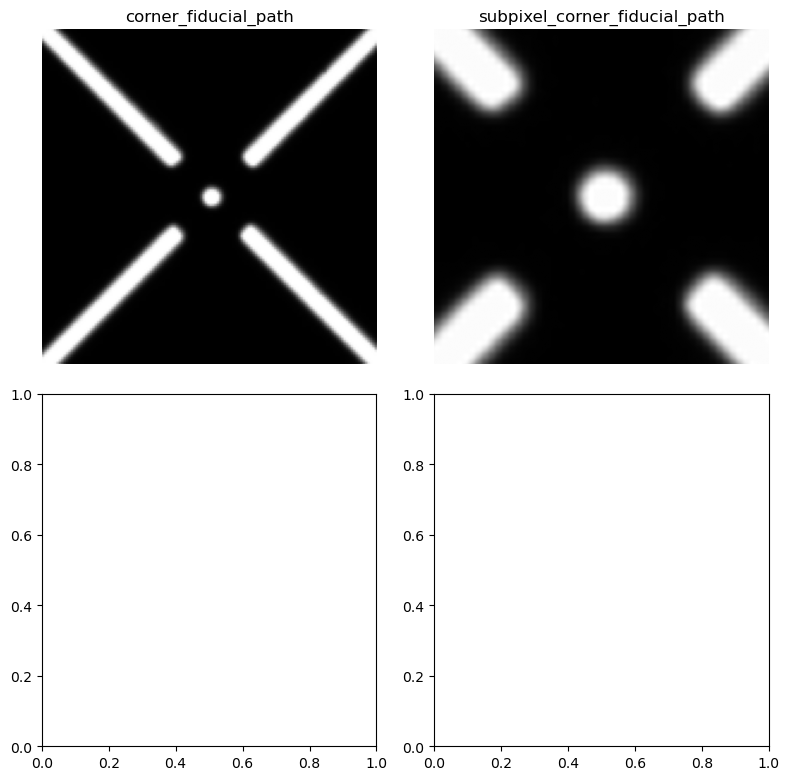

In [10]:
first_image_path = sorted(paths["a71_19"]["raw_images"].glob("*.tif"))[0]
saved_coords_corners =  {'fiducial_coordinate': (1687, 976), 'subpixel_center_coordinate': (563, 562)}

_ = hipp.aerial.create_fiducial_templates(
    first_image_path, 
    paths["a71_19"]["fiducial_templates"],
    corner=True,
    distance_around_fiducial=70,
    subpixel_distance_around_fiducial=200,
    **saved_coords_corners)

# Copy fiducials template for other 1971 dataset, cause the same fiducial are used
shutil.copytree(paths["a71_19"]["fiducial_templates"], paths["a71_24"]["fiducial_templates"], dirs_exist_ok=True)
shutil.copytree(paths["a71_19"]["fiducial_templates"], paths["a71_25"]["fiducial_templates"], dirs_exist_ok=True)

hipp.aerial.qc.plot_fiducial_templates(paths["a71_19"]["fiducial_templates"])

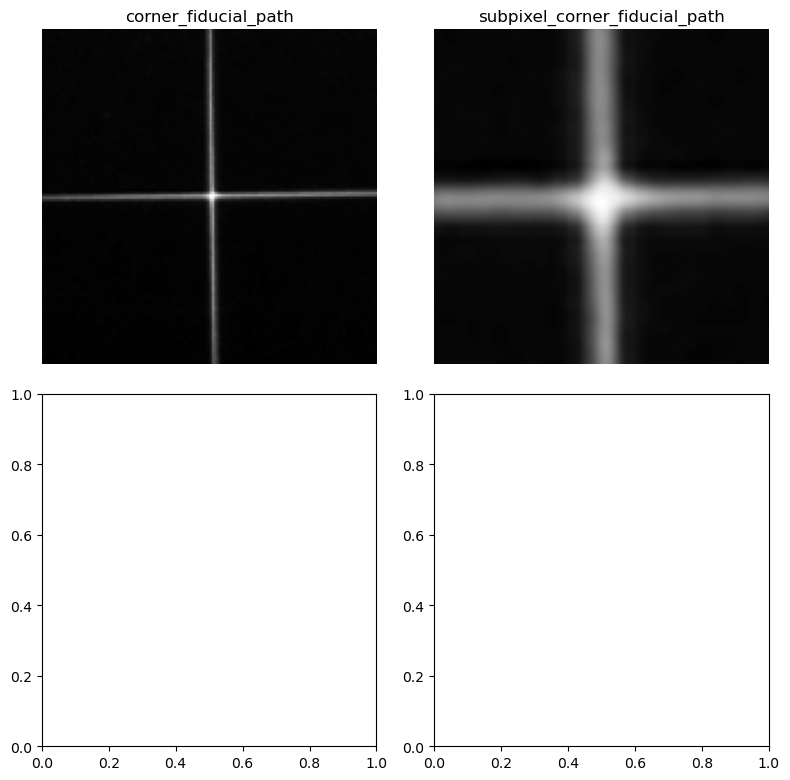

In [11]:
first_image_path = sorted(paths["a90"]["raw_images"].glob("*.tif"))[0]
saved_coords_corners = {'fiducial_coordinate': (1236, 656), 'subpixel_center_coordinate': (568, 556)}

_ = hipp.aerial.create_fiducial_templates(
    first_image_path, 
    paths["a90"]["fiducial_templates"], 
    corner=True,
    distance_around_fiducial=70,
    **saved_coords_corners)

hipp.aerial.qc.plot_fiducial_templates(paths["a90"]["fiducial_templates"])

## Fiducial Detection

In [12]:
for p in paths.values():
    # fiducials detection
    detected_fiducials_df = hipp.aerial.iter_detect_fiducials(p["raw_images"], p["fiducial_templates"], grid_size=7, max_workers=MAX_WORKERS)
    
     # filter detection and save the result
    filtered_detected_fiducials_df = hipp.aerial.filter_detected_fiducials(detected_fiducials_df)
    filtered_detected_fiducials_df.round(2).to_csv(p["detected_fiducials"])

    # plot matching score
    output_plot_path = p["qc"] / "detection_score_boxplot.png"
    hipp.aerial.qc.plot_detection_score_boxplot(detected_fiducials_df, show=False, output_plot_path=output_plot_path)

    # plot fiducials filtering
    output_plot_path = p["qc"] / "fiducials_filtering.png"
    hipp.aerial.qc.plot_fiducials_filtering(detected_fiducials_df,filtered_detected_fiducials_df, show=False, output_plot_path=output_plot_path)

    # plot individuals detection
    output_dir = p["qc"] / "individual_detections"
    hipp.aerial.qc.generate_detection_qc_plots(p["raw_images"], detected_fiducials_df, output_dir)

   

Fiducial detections: 100%|████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.55Image/s]


## Image restitution

In [14]:
for p in paths.values():
    scanning_resolution_mm, true_fiducials_mm = hipp.aerial.open_camera_model_intrinsics(p["intrinsics"])

    # here we take result image of 9 inchs (228.6 mm) because it's the size of aerial images
    # we minus 5 px to be avoid some black borders
    # can be apply with 208 mm to have no artifacts
    image_square_dim = int(228.6 / scanning_resolution_mm) -5
    df = pd.read_csv(p["detected_fiducials"], index_col="image_id")

    transformations = hipp.aerial.compute_transformations(df, true_fiducials_mm, image_square_dim, scanning_resolution_mm)

    # save the transformed detected fiducial markers (coordinate of fiducials in preprocessed images)
    p["tf_detected_fiducials"].parent.mkdir(parents=True, exist_ok=True)
    hipp.aerial.warp_fiducials_df(df, transformations).round(2).to_csv(p["tf_detected_fiducials"])

    # plot the correction to ensure it's correct
    output_plot_path = p["qc"] / "fiducials_correction.png"
    hipp.aerial.qc.plot_fiducials_correction(df, transformations, true_fiducials_mm, scanning_resolution_mm, False, output_plot_path)

    hipp.aerial.iter_image_restitution(
        p["raw_images"], 
        p["preproc_images"], 
        transformations,
        image_square_dim=image_square_dim,
        max_workers=MAX_WORKERS,
        overwrite=OVERWRITE
    )
    hipp.tools.generate_quickviews(p["preproc_images"],QUICKVIEW_FACTOR, max_workers=MAX_WORKERS, overwrite=OVERWRITE)

0it [00:00, ?it/s]
Generating quickviews: 100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [04:42<00:00,  2.32s/image]
0it [00:00, ?it/s]
Generating quickviews: 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:09<00:00,  5.75s/image]
0it [00:00, ?it/s]
Generating quickviews: 100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.43s/image]
0it [00:00, ?it/s]
Generating quickviews: 100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [01:36<00:00,  5.65s/image]
